###**IMAGE SEGMENTATION TO HOMOGENIZE PIXEL COLORS USING K-MEANS CLUSTERING**
####*Author: Matt Boraske*

Load Input Image

In [18]:
# Input picture.
# WARNING - THIS CODE ONLY WORKS FOR PNG IMAGES
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving embiid.png to embiid (2).png
User uploaded file "embiid.png" with length 823324 bytes


Image Processing Functions

In [19]:
from __future__ import division
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
import numpy as np
import scipy as sp
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

"""Helper image-processing code."""
def image_to_matrix(image_file, grays=False):
    """
    Convert .png image to matrix
    of values.
    
    params:
    image_file = str
    grays = Boolean
    
    returns:
    img = (color) np.ndarray[np.ndarray[np.ndarray[float]]] 
    or (grayscale) np.ndarray[np.ndarray[float]]
    """
    img = image.imread(image_file)
    #In case of transparency values
    if(len(img.shape) == 3 and img.shape[2] > 3):
        height, width, depth = img.shape
        new_img = np.zeros([height, width, 3])
        for r in range(height):
            for c in range(width):
                new_img[r,c,:] = img[r,c,0:3]
        img = np.copy(new_img)
    if(grays and len(img.shape) == 3):
        height, width = img.shape[0:2]
        new_img = np.zeros([height, width])
        for r in range(height):
            for c in range(width):
                new_img[r,c] = img[r,c,0]
        img = new_img
    #Clean up zeros
    if(len(img.shape) == 2):
        zeros = np.where(img == 0)[0]
        img[zeros] += 1e-7
    return img

def matrix_to_image(image_matrix, image_file):
    """
    Convert matrix of color/grayscale 
    values  to .png image
    and save to file.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    image_file = str
    """
    #Provide cmap to grayscale images
    cMap = None
    if(len(image_matrix.shape) < 3):
        cMap = cm.Greys_r
    
    image.imsave(image_file, image_matrix, cmap=cMap)
    #image.imsave(image_file, image_matrix, cmap=cm.Greys_r)

    #If using Google Colab
    files.download(image_file)
    
def image_width(image_matrix):
    if(len(image_matrix.shape) == 3):
        height, width, depth = image_matrix.shape
    else:
        height, width = image_matrix.shape
    return width
    
def flatten_image_matrix(image_matrix):
    """
    Flatten image matrix from 
    Height by Width by Depth
    to (Height*Width) by Depth
    matrix.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    
    returns:
    flattened_values = (color) numpy.ndarray[numpy.ndarray[float]] or (grayscale) numpy.ndarray[float]    
    """
    if(len(image_matrix.shape) == 3):
        height, width, depth = image_matrix.shape
    else:
        height, width = image_matrix.shape
        depth = 1
    flattened_values = np.zeros([height*width,depth])
    for i, r in enumerate(image_matrix):
        for j, c in enumerate(r):
            flattened_values[i*width+j,:] = c
    return flattened_values

def unflatten_image_matrix(image_matrix, width):
    """
    Unflatten image matrix from
    (Height*Width) by Depth to
    Height by Width by Depth matrix.
    
    params:
    image_matrix = (color) numpy.ndarray[numpy.ndarray[float]] or (grayscale) numpy.ndarray[float]
    width = int
    
    returns:
    unflattened_values = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    """
    heightWidth = image_matrix.shape[0]
    height = int(heightWidth / width)
    if(len(image_matrix.shape) > 1):
        depth = image_matrix.shape[-1]
        unflattened_values = np.zeros([height, width, depth])
        for i in range(height):
            for j in range(width):
                unflattened_values[i,j,:] = image_matrix[i*width+j,:]
    else:
        depth = 1
        unflattened_values = np.zeros([height, width])
        for i in range(height):
            for j in range(width):
                unflattened_values[i,j] = image_matrix[i*width+j]
    return unflattened_values

def image_difference(image_values_1, image_values_2):
    """
    Calculate the total difference 
    in values between two images.
    Assumes that both images have same
    shape.
    
    params:
    image_values_1 = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    image_values_2 = (color) numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] or (grayscale) numpy.ndarray[numpy.ndarray[float]]
    
    returns:
    dist = int
    """
    flat_vals_1 = flatten_image_matrix(image_values_1)
    flat_vals_2 = flatten_image_matrix(image_values_2)
    N, depth = flat_vals_1.shape
    dist = 0.
    point_thresh = 0.005
    for i in range(N):
        if(depth > 1):
            new_dist = sum(abs(flat_vals_1[i] - flat_vals_2[i]))
            if(new_dist > depth * point_thresh):
                dist += new_dist
        else:
            new_dist = abs(flat_vals_1[i] - flat_vals_2[i])
            if(new_dist > point_thresh):
                dist += new_dist
    return dist



Plot of image RGB Values

Enter the file name of an image: embiid_gmm.png


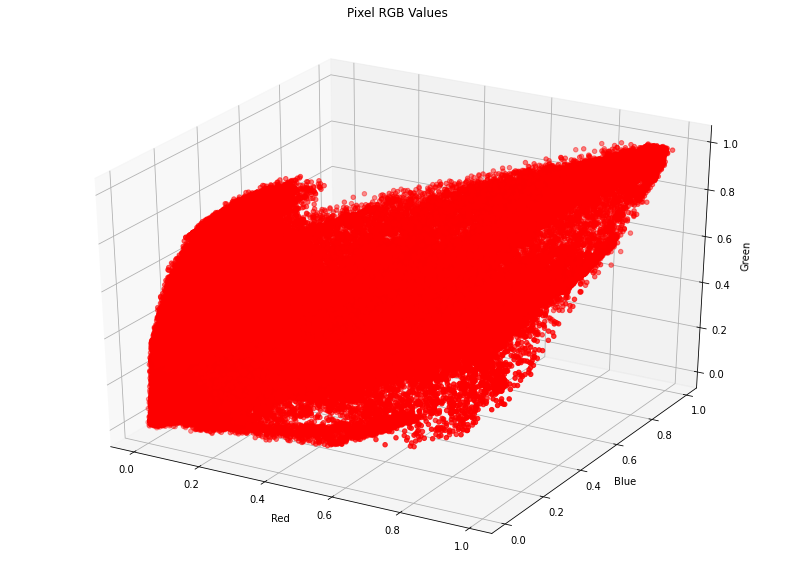

In [21]:
#Plot RGB values of pixels
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_RGB(image_name):
  image_values = image_to_matrix(image_name)
  flat_image = flatten_image_matrix(image_values)
  R = flat_image[:,0]
  G = flat_image[:,1]
  B = flat_image[:,2]

  fig = plt.figure(figsize=(14,10))
  ax = fig.add_subplot(111, projection='3d')

  R = flat_image[:,0]
  G = flat_image[:,1]
  B = flat_image[:,2]

  ax.scatter(R, G, B, c='r', marker='o')
  ax.title.set_text('Pixel RGB Values')
  ax.set_xlabel('Red')
  ax.set_ylabel('Blue')
  ax.set_zlabel('Green')

  plt.show()

image_name = input("Enter the file name of an image: ")
plot_RGB(image_name)

Manual implementation of k-means clustering algortihm

In [22]:
from random import randint
from math import sqrt
from functools import reduce
import pandas as pd

def k_means_cluster(image_values, k, iterations):
    """
    Separate the provided RGB values into
    k separate clusters using the k-means algorithm,
    then return an updated version of the image
    with the original values replaced with
    the corresponding cluster values.
    
    params:
    image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None
    
    returns:
    updated_image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]]
    """
  
    def calc_distance(pix,clustMean):
      """
      Returns Euclidean distance between 2 points
      
      params:
      pix = [float,float,float]
      clustMean = [float,float,float]

      returns:
      d = float
      """
      d = sqrt( (pix[0]-clustMean[0])*(pix[0]-clustMean[0]) + (pix[1]-clustMean[1])*(pix[1]-clustMean[1]) + (pix[2]-clustMean[2])*(pix[2]-clustMean[2]) )    
      return d
  
    def assign_clusters(centroids, pixels):
      clusters = []
      """
      Assigns pixels to a cluster      

      params:
      centroids = numpy.ndarray[numpy.ndarray[float]]
      pixels = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]
      
      returns:
      clusters = list(int)
      """
      
      for i in range(pixels.shape[0]):
          distances = []
          for centroid in centroids:
              distances.append(calc_distance(centroid, 
                                            pixels[i]))
          cluster = [z for z, val in enumerate(distances) if val==min(distances)]
          clusters.append(cluster[0])
      return clusters

    def calc_centroids(clusters, pixels):
      """
      Calculates centroid(mean) of a cluster   

      params:
      cluster = numpy.ndarray[int]
      pixels = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]
      
      returns:
      new_centroids = list([numpy.ndarray[float]])
      """
      new_centroids = []
      cluster_df = pd.concat([pd.DataFrame(pixels),
                              pd.DataFrame(clusters, 
                                          columns=['cluster'])], 
                            axis=1)
      for c in set(cluster_df['cluster']):
          current_cluster = cluster_df[cluster_df['cluster']\
                                      ==c][cluster_df.columns[:-1]]
          cluster_mean = current_cluster.mean(axis=0)
          new_centroids.append(cluster_mean)
      new_centroids = np.array(new_centroids)
      return new_centroids  

    # Flatten the image matrix
    imHeight,imWidth,imDep = np.shape(image_values)
    flat_image = flatten_image_matrix(image_values)
    numPix, rgbdim = np.shape(flat_image)    
    updated_image_values = np.copy(flat_image)

    #Choose unique random pixels as initial centroids
    number_of_rows = updated_image_values.shape[0]

    #Generate initial centroids until they are unique
    while True:
      random_indices = np.random.choice(number_of_rows, size=k, replace=True)
      centroids = updated_image_values[random_indices, :]
      unique_centroids = np.unique(centroids, axis=0)
      #break and continue with program if k unique centroids exist
      if (len(unique_centroids) == k):
        break

    #Assign initial clusters
    clusters = assign_clusters(centroids, updated_image_values)
    clusters = np.array(clusters)

    #Update clusters
    for i in range(iterations):
      #update centroids
      centroids = calc_centroids(clusters, updated_image_values)
      #update clusters
      clusters = assign_clusters(centroids, updated_image_values)   

    #Change value of each pixel to that of its clusters mean
    score = 0
    for i in range(len(updated_image_values)):
      for value in np.arange(len(centroids)):
        if clusters[i] == value:
          score = score + calc_distance(updated_image_values[i], centroids[value])
          updated_image_values[i] = centroids[value]

    #Unflatten the image matrix with the updated values.
    updated_image_values_sqr = unflatten_image_matrix(updated_image_values,imWidth)

    #Return the unflattened matrix.
    return updated_image_values_sqr, score


Function to run k-means clustering algorithm

In [25]:
def k_means_run(image, k, iterations):
    """
    Testing your implementation
    of k-means on the segmented
    reference images.

    params:
    k = number of clusters 
    """
    #Convert image to RGB matrix
    image_values = image_to_matrix(image_name)

    #Call k-means.
    updated_values, score = k_means_cluster(image_values, k, iterations)
    
    #Convert the output pixels from matrix to image. Save the output image.
    ref_image = 'k%d_%s'%(k, image_name)
    matrix_to_image(updated_values, ref_image)

    #Return score of clustering (for elbow curve)
    return score

image_name = input("Enter the file name of an image: ")
starting_k = input("Enter a starting k value: ")
starting_k = int(starting_k)
ending_k = input("Enter an ending k value: ")
ending_k = int(ending_k)
iterations = input("Enter how many iterations for the k-means algorithm: ")

for k in np.arange(starting_k,ending_k+1):
  k_means_run(image_name, k=k, iterations = 5)

Enter the file name of an image: embiid_kmeans.png
Enter a starting k value: 2
Enter an ending k value: 3
Enter how many iterations for the k-means algorithm: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Elbow curve for manual K-Means to identify the number of clusters that should be used to adequately represent the image.


Enter the file name of an image: embiid_kmeans.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

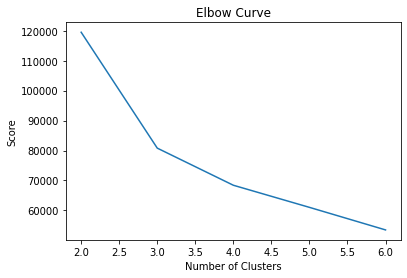

In [28]:
#Elbow curve to evalute k-means clusters
image_name = input("Enter the file name of an image: ")
scores = []
clusters_array = np.arange(2,7)

for k in clusters_array:
  scores.append(k_means_run(image_name, k=k, iterations = 3))

scores_array = np.array(scores)

plt.figure()
plt.plot(clusters_array,scores)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

Implementation of k-means using scikit-learn library

In [33]:
from sklearn.cluster import KMeans
def scikit_KMeans(image, k):
  #Number of clusters
  numClusters = k

  #Prepare pixel data by flattening image matrix
  image_values = image_to_matrix(image)
  imHeight,imWidth,imDep = np.shape(image_values)
  flat_image = flatten_image_matrix(image_values)
  updated_image_values = np.copy(flat_image)

  #Call scikit k-means
  kmeans = KMeans(n_clusters= k, random_state=0).fit(updated_image_values)

  #Change color of each pixel to that of its clusters mean
  for i in range(len(updated_image_values)):
    for value in np.arange(len(kmeans.cluster_centers_)):
      if kmeans.labels_[i] == value:
        updated_image_values[i] = kmeans.cluster_centers_[value]

  #Unflatten the image matrix
  updated_image_values_sqr = unflatten_image_matrix(updated_image_values,imWidth)

  #Save the output image
  ref_image = 'k%d_%s'%(k, image)
  matrix_to_image(updated_image_values_sqr, ref_image)

#Run k-means
image_name = input("Enter the file name of an image: ")
starting_k = input("Enter a starting k value: ")
starting_k = int(starting_k)
ending_k = input("Enter an ending k value: ")
ending_k = int(ending_k)
for k in np.arange(starting_k,ending_k+1):
  scikit_KMeans(image_name, k)

Enter the file name of an image: embiid_scikit_kmeans.png
Enter a starting k value: 2
Enter an ending k value: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Image segmentation using scikit-learn gaussian mixture models

In [35]:
from sklearn.mixture import GaussianMixture
def scikit_GMM(image, n):
  #Set number of clusters
  numComponents = n

  #Flatten image matrix
  image_values = image_to_matrix(image)
  imHeight,imWidth,imDep = np.shape(image_values)
  flat_image = flatten_image_matrix(image_values)
  updated_image_values = np.copy(flat_image)

  #Call scikit GMM
  gmm = GaussianMixture(n_components=n)
  gmm.fit(updated_image_values)
  predictions = gmm.predict(updated_image_values)

  #Change value of each pixel to that of its clusters mean
  for i in range(len(updated_image_values)):
    for value in np.arange(len(gmm.means_)):
      if predictions[i] == value:
        updated_image_values[i] = gmm.means_[value]

  #Unflatten the image matrix
  updated_image_values_sqr = unflatten_image_matrix(updated_image_values,imWidth)

  #Convert the output pixels from matrix to image

  #Save the output image
  ref_image = 'k%d_%s'%(k, image)
  matrix_to_image(updated_image_values_sqr, ref_image)

#Run GMM
image_name = input("Enter the file name of an image: ")
starting_k = input("Enter a starting k value: ")
starting_k = int(starting_k)
ending_k = input("Enter an ending k value: ")
ending_k = int(ending_k)
for k in np.arange(starting_k,ending_k+1):
  scikit_GMM(image_name,k)

Enter the file name of an image: embiid_gmm.png
Enter a starting k value: 2
Enter an ending k value: 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>